<a href="https://colab.research.google.com/github/harshgiri9/Machine-learning-Internship/blob/master/bitcon_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import pandas
import numpy
import datetime
import requests
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation


class Funcs:

    def __init__(self):
        self.min_max_scaler = preprocessing.MinMaxScaler()

    # Last 5Y picton price only 'close' price
    def Get_Historicalprice(self):
        endpoint = 'https://min-api.cryptocompare.com/data/histoday'
        res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
        jobject = pandas.DataFrame(json.loads(res.content)['Data'])
        df = pandas.DataFrame(jobject, columns=['time', 'close'])
        df = df.set_index('time')
        df.index = pandas.to_datetime(df.index, unit='s')
        date_from = datetime.datetime.now() - datetime.timedelta(days=(5*365.24))
        date_from = date_from.strftime("%Y-%m-%d")
        # date_to = datetime.datetime.now()
        df = df.loc[date_from:]
        return df

    # Normalize a dataframe with min max scaler
    def Normalize(self, df):
        x = df.values
        x_scaled = self.min_max_scaler.fit_transform(x)
        df = pandas.DataFrame(x_scaled, df.index)
        return df

    # Denormalize a dataframe from last min max scaler
    def Denormalize(self, x_scaled):
        x_orginal = self.min_max_scaler.inverse_transform(x_scaled)
        return x_orginal

    # split Data to Train and Test
    def Split_Test_Train(self, df, Test_size=0.1):
        sp = len(df)-Test_size
        Train = df[:sp]
        Test = df[sp:]
        return Train, Test

    # Conver Time series to Supervised Learning
    def Convert_TS_To_SL(self, data, window_size):
        temp_data = data.copy()
        for i in range(window_size):
            temp_data = pandas.concat([temp_data, data.shift(-(i+1))], axis=1)
        temp_data.dropna(inplace=True)
        temp_data = temp_data.iloc[:, :-1]
        return temp_data

    def build_LSTM(self, window_size, features=1):
        model = Sequential()
        model.add(LSTM(20, input_shape=(window_size, features)))
        model.add(Dropout(0.25))
        model.add(Dense(units=1))
        model.add(Activation('linear'))
        model.compile(loss="mae", optimizer="adam")
        return model

    def build_NextDays(self, df, days, window_size, model, features=1):
        df = df[len(df)-window_size:]
        predictdf = pandas.DataFrame()
        for i in range(0, days):
            dfarray = numpy.array(df.values)
            dfarray = dfarray.reshape(1, window_size, features)
            predictvalue = model.predict(dfarray)
            df = df.drop(df.index[0])
            last_date = df.iloc[[-1]].index
            last_date = last_date + datetime.timedelta(days=1)
            df = df.append(pandas.DataFrame(predictvalue, index=last_date))
            predictdf = predictdf.append(
                pandas.DataFrame(predictvalue, index=last_date))
        return predictdf

 Welcome to Bitcoin Price Predicon ver 0.1
 Data     Shape : (1827, 1)
 Train    Shape : (1647, 1)
 Test     Shape : (180, 1)
 X_Train  Shape : (1640, 7)
 X_Test   Shape : (173, 7)
 Y_Train  Shape : (1640, 1)
 Y_Test   Shape : (173, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
410/4

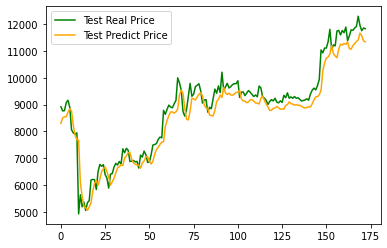

No handles with labels found to put in legend.


[[11324.964 ]
 [11023.064 ]
 [10696.8   ]
 [10371.616 ]
 [10055.644 ]
 [ 9756.535 ]
 [ 9478.876 ]
 [ 9222.092 ]
 [ 8981.994 ]
 [ 8759.6455]
 [ 8553.514 ]
 [ 8362.194 ]
 [ 8184.3545]
 [ 8018.7866]
 [ 7864.4126]
 [ 7720.251 ]
 [ 7585.3896]
 [ 7459.0347]
 [ 7340.4707]
 [ 7229.064 ]
 [ 7124.242 ]
 [ 7025.4956]
 [ 6932.365 ]
 [ 6844.439 ]
 [ 6761.3413]
 [ 6682.736 ]
 [ 6608.3154]
 [ 6537.8   ]
 [ 6470.9346]
 [ 6407.4863]
 [ 6347.2393]
 [ 6289.9985]
 [ 6235.5806]
 [ 6183.82  ]
 [ 6134.5605]
 [ 6087.658 ]
 [ 6042.9805]
 [ 6000.4033]
 [ 5959.8105]
 [ 5921.0957]
 [ 5884.159 ]
 [ 5848.9053]
 [ 5815.2476]
 [ 5783.103 ]
 [ 5752.395 ]
 [ 5723.0513]
 [ 5695.003 ]
 [ 5668.1875]
 [ 5642.543 ]
 [ 5618.0137]
 [ 5594.5454]
 [ 5572.088 ]
 [ 5550.5933]
 [ 5530.0156]
 [ 5510.3135]
 [ 5491.4463]
 [ 5473.3745]
 [ 5456.0635]
 [ 5439.4775]
 [ 5423.5845]
 [ 5408.353 ]
 [ 5393.7544]
 [ 5379.76  ]
 [ 5366.3433]
 [ 5353.4785]
 [ 5341.1426]
 [ 5329.3115]
 [ 5317.965 ]
 [ 5307.0806]
 [ 5296.6387]
 [ 5286.621 ]
 [ 527

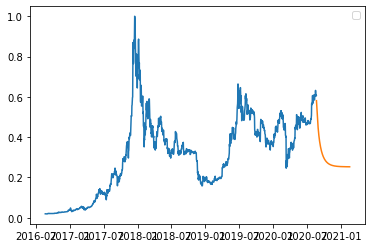

In [4]:


import numpy
import datetime
import pandas


from matplotlib import pyplot as plt


print(" Bitcoin Price Prediction")


hp = Funcs()  # Init Hepler class
# ===========================================================
Data = hp.Get_Historicalprice()  # get data
print(" Data     Shape : " + str(Data.shape))
# ===========================================================
Org_data = Data.copy()  # Make copy of org data -_o
# ===========================================================
Data = hp.Normalize(Data)  # normalize data
# ===========================================================
LastdaysForTest = 180
Train, Test = hp.Split_Test_Train(Data, LastdaysForTest)  # splitdata
print(" Train    Shape : " + str(Train.shape))
print(" Test     Shape : " + str(Test.shape))
# ===========================================================
window_size = 7
features = 1
# ===========================================================
X_Train = hp.Convert_TS_To_SL(Train, window_size)
X_Test = hp.Convert_TS_To_SL(Test, window_size)
Y_Train = Train[window_size:].values
Y_Test = Test[window_size:].values
print(" X_Train  Shape : " + str(X_Train.shape))
print(" X_Test   Shape : " + str(X_Test.shape))
print(" Y_Train  Shape : " + str(Y_Train.shape))
print(" Y_Test   Shape : " + str(Y_Test.shape))
# ===========================================================
ep = 30
bs = 4
LSTM_Model = hp.build_LSTM(window_size, features)
LSTM_Model.summary()
# ===========================================================
X_Train = numpy.array(X_Train.values)
X_Train = X_Train.reshape(len(X_Train), window_size, features)
Y_Train = Y_Train.reshape(len(Y_Train), )
# ===========================================================
history = LSTM_Model.fit(X_Train, Y_Train, epochs=ep, batch_size=bs)  # Train
# ===========================================================
X_Test = numpy.array(X_Test.values)
X_Test = X_Test.reshape(len(X_Test), window_size, features)
Y_Test = Y_Test.reshape(len(Y_Test), )  # Reshape Y_Test for Evaluate
# ===========================================================
PY_Test = LSTM_Model.predict(X_Test)  # Predict Y_Test
# ===========================================================
history = LSTM_Model.evaluate(X_Test, Y_Test)  # Evaluate Model -_o
# ===========================================================
Y_Test = Y_Test.reshape(len(Y_Test), features)  # Reshape Y_Test back
# ===========================================================
print(Y_Test)
print(PY_Test)
plt.plot(hp.Denormalize(Y_Test), color='green', label='Test Real Price')
plt.plot(hp.Denormalize(PY_Test), color='orange', label='Test Predict Price')
plt.legend() 
plt.show()
# ===========================================================
daystopredict = 180
nextdays = hp.build_NextDays(Data, daystopredict, window_size, LSTM_Model)
print(hp.Denormalize(nextdays.values))
plt.plot(Data[365:])
plt.plot(nextdays)
plt.legend()
plt.show()